## Water Injection Dredging 
This notebook is made to simulate the workflow of a Water Injection Dredger (WID). This method is conducted by Water Injection Dredgers (WID) by injecting water with a jetbar and multiple nozzles to the sediment bed, fluidize the sediments, and leads the sediments to the open sea using currents and waves.

The WID module is generated by defining a "processor_wid" mixin and "produce_amount_activity" activity.

The production via "produce_amount_activity" continues until the condition of WhileActivity meets. There will be no discharging location in this case.

#### 0. Import libraries

In [109]:
# import datetime, time
import simpy
import shapely.geometry
import pandas as pd
import inspect
import sys 
import os 
import matplotlib.pyplot as plt

import openclsim.core as core
import openclsim.model as model
import openclsim.plot as plot
import openclsim.plugins as plugins

#### 1. Initialise simpy environment

In [110]:
simulation_start = 0
my_env = simpy.Environment(initial_time=simulation_start)

#### 2. Define object classes

In [111]:
Site = type(
    "Site",
    (
        core.Identifiable,
        core.Log,
        core.Locatable,
        core.HasContainer,
        core.HasResource,
    ),
    {},
)
TransportProcessingResource = type(
    "TransportProcessingResource",
    (
        core.ContainerDependentMovable, 
        core.HasResource,
        core.Processor_wid,
        core.Identifiable,
        core.Log,
    ),
    {},
)

#### 3. Create Objects

##### 3.1. Create site object(s)

In [112]:
# prepare input data for from_site
location_from_site = shapely.geometry.Point(4.057883, 51.947782)

data_from_site = {
    "env": my_env,
    "name": "from_site",
    "geometry": location_from_site,    
    "capacity":150000,
    "level":150000,
}
# instantiate from_site
from_site = Site(**data_from_site)

##### 3.2. Create vessel object(s)

In [113]:
# prepare input data for vessel_01
data_vessel01 = {
    "env": my_env,
    "name": "vessel01",
    "geometry": location_from_site,  
    "capacity":1740,        # capacity doesn't matter in the WID as no re-allocation is done
    "compute_v": lambda x: 10
}
# instantiate vessel_01 
vessel01 = TransportProcessingResource(**data_vessel01)

##### 3.3. Create activity/activities

In [114]:
# initialise registry
registry = {}

In [115]:
# create a list of the sub processes
sub_processes = [
    model.ProduceAmountActivity(
        env=my_env,
        WIDprocessor=vessel01,
        destination = vessel01,
        origin=from_site,
        name='dredging_wid',
        registry=registry,
        amount=1740,
        duration=2*3600,
    ),
]
# create a while activity that executes the 'sequential activity' while the stop condition is not triggered
while_activity = model.WhileActivity(
    env=my_env,
    name='While activity',
    registry=registry,
    sub_processes=sub_processes,
    condition_event=[
        {"type":"container", "concept":from_site,"state":"empty"}
    ],
)

#### 4. Register processes and run simpy

In [116]:
model.register_processes([while_activity])
my_env.run()

### 5. Inspect results

##### 5.1. Create logs

In [117]:
df_WID = pd.concat(
    [
        plot.get_log_dataframe(vessel01, [while_activity, *sub_processes])
        for act in sub_processes
    ]
).sort_values(by=['Timestamp'])
df_SITE = pd.concat(
    [
        plot.get_log_dataframe(from_site, [while_activity, *sub_processes])
        for act in sub_processes
    ]
).sort_values(by=['Timestamp'])

##### 5.2. Inspect logs

In [118]:
display(plot.get_log_dataframe(vessel01, [while_activity, *sub_processes]))

,Activity,Timestamp,ActivityState,geometry,container level
0,dredging_wid,1970-01-01 00:00:00,START,POINT (4.057883 51.947782),0.0
1,dredging_wid,1970-01-01 02:00:00,STOP,POINT (4.057883 51.947782),0.0
2,dredging_wid,1970-01-01 02:00:00,START,POINT (4.057883 51.947782),0.0
3,dredging_wid,1970-01-01 04:00:00,STOP,POINT (4.057883 51.947782),0.0
4,dredging_wid,1970-01-01 04:00:00,START,POINT (4.057883 51.947782),0.0
...,...,...,...,...,...
169,dredging_wid,1970-01-08 02:00:00,STOP,POINT (4.057883 51.947782),0.0
170,dredging_wid,1970-01-08 02:00:00,START,POINT (4.057883 51.947782),0.0
171,dredging_wid,1970-01-08 04:00:00,STOP,POINT (4.057883 51.947782),0.0
172,dredging_wid,1970-01-08 04:00:00,START,POINT (4.057883 51.947782),0.0


##### 5.3. Inspect from_site

In [119]:
display(plot.get_log_dataframe(from_site, [while_activity]))

,Activity,Timestamp,ActivityState,container level,geometry
0,dredging_wid,1970-01-01 00:00:00,START,150000,POINT (4.057883 51.947782)
1,dredging_wid,1970-01-01 02:00:00,STOP,148260,POINT (4.057883 51.947782)
2,dredging_wid,1970-01-01 02:00:00,START,148260,POINT (4.057883 51.947782)
3,dredging_wid,1970-01-01 04:00:00,STOP,146520,POINT (4.057883 51.947782)
4,dredging_wid,1970-01-01 04:00:00,START,146520,POINT (4.057883 51.947782)
...,...,...,...,...,...
169,dredging_wid,1970-01-08 02:00:00,STOP,2100,POINT (4.057883 51.947782)
170,dredging_wid,1970-01-08 02:00:00,START,2100,POINT (4.057883 51.947782)
171,dredging_wid,1970-01-08 04:00:00,STOP,360,POINT (4.057883 51.947782)
172,dredging_wid,1970-01-08 04:00:00,START,360,POINT (4.057883 51.947782)


##### 5.4. Visualise step chart

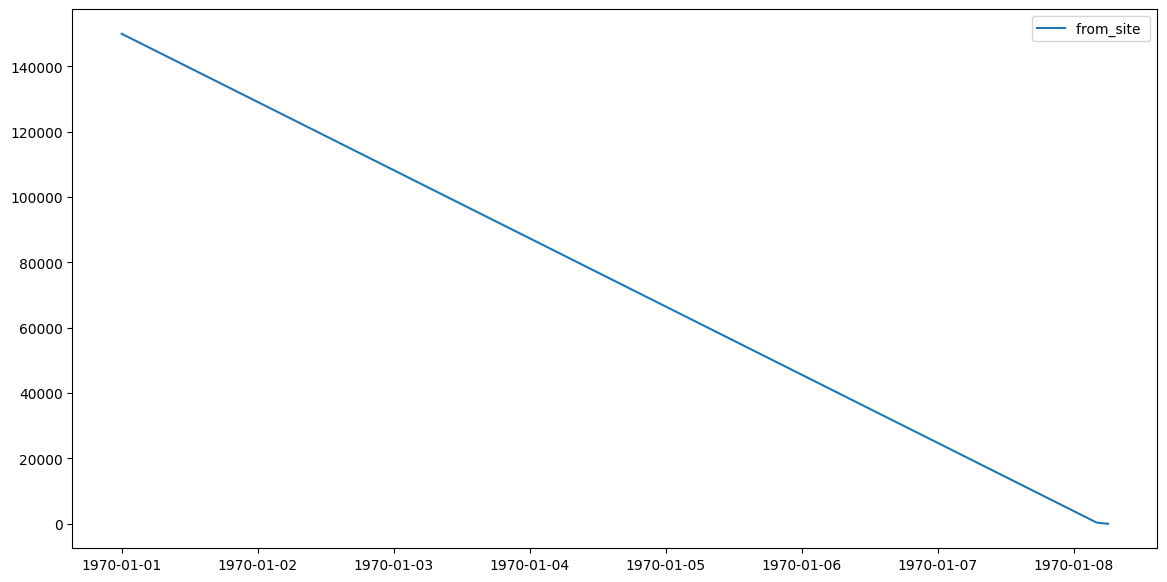

In [120]:
fig = plot.get_step_chart([from_site])

##### 5.5. Visualise gantt chart

In [121]:
plot.get_gantt_chart([vessel01, from_site],id_map=[while_activity, *sub_processes])